In [1]:
from spectral import open_image, msam
import pysptools.eea as eea #for extracting endmembers
from xarr_helpers import extract_from_NEON
import geopandas as gpd
import fiona
from matplotlib import pyplot as plt
from matplotlib import gridspec
import numpy as np

import pysptools.util as util
import pysptools.eea as eea
import pysptools.abundance_maps as amp
from pysptools.classification import SAM
from earthpy.spatial import bytescale
# from shapely.geometry import mapfor xarr_VNIR, x_vnir, y_vnir, xarr_SWIR, x_swir, y_swir in zip(xarr_VNIR_ls, x_vnir_ls, y_vnir_ls, xarr_SWIR_ls, x_swir_ls, y_swir_ls):ping, box

D:\Ian\Applications\Anaconda\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
D:\Ian\Applications\Anaconda\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [4]:
# Import raw data
bin_path = '../headwall_data/Radiance/SWIR_CUSouth/headwall_CUS_block0_swir_rad_glt_cor.hdr'
data, header = util.load_ENVI_file(bin_path)
hsi_cube = np.nan_to_num(np.fliplr(data)) # must get rid of nans and fliplr for get_endmembers
mask = (hsi_cube[:,:,20]) != 0.0 # not ideal
# data is mxnx(wavelengths) raw pixel values. Similar to img below.

D:\Ian\Applications\Anaconda\lib\site-packages\spectral\io\spyfile.py:252: NaNValueWarning: Image data contains NaN values.
  warnings.warn('Image data contains NaN values.', NaNValueWarning)


In [5]:
# get endmembers using nfindr
# https://pysptools.sourceforge.io/_downloads/nbex_methanol_burner.html
def get_endmembers(data, header, em_num, display):
    print('Endmembers extraction with NFINDR')
    nfindr = eea.NFINDR()
    U = nfindr.extract(data, em_num, maxit=5, normalize=False, ATGP_init=True)
    if display:
        nfindr.display(header, suffix='graph')
    # return an array of endmembers
    return U


U = get_endmembers(hsi_cube, header, em_num = 6, display = False)

Endmembers extraction with NFINDR


In [6]:
print(U.shape[0])
print(U[0].shape)

6
(270,)


In [7]:
# get endmembers using hardcoded position vec
def get_vec(data, pos):
    return data[pos[0],pos[1],:]

#em = get_vec(hsi_cube, (150, 200))# tennis court pixel
em0 = get_vec(hsi_cube, (100, 200))
em1 = get_vec(hsi_cube, (110, 200))
em2 = get_vec(hsi_cube, (120, 200))
em3 = get_vec(hsi_cube, (130, 200))

em = get_vec(hsi_cube, (130, 200))
em = (em0 + em1 + em2 + em3) / 4

em.shape

(270,)

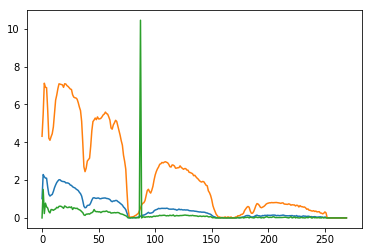

In [8]:
plt.plot(em)
plt.plot(U[U.shape[0]-1])
plt.plot(U[0])

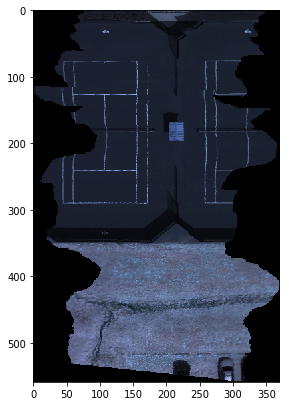

In [9]:
def show_rgb(input_img):
    # Not really RGB for headwall data bc seemingly no RBG bands given. But it's close.
    fig = plt.figure(figsize=(20,8))
    gs = gridspec.GridSpec(1, 3, width_ratios=[2, 1, 1])
    ax1 = plt.subplot(gs[1])
    tmp = ax1.imshow(bytescale(input_img[:,:,[54, 34, 22]])) #54/34/22<->R/G/B
    
def show_grayscale(input_img):
    fig = plt.figure(figsize=(20,8))
    gs = gridspec.GridSpec(1, 3, width_ratios=[8, 1, 1])
    ax1 = plt.subplot(gs[1])
    tmp = ax1.imshow(bytescale(input_img)) #54/34/22<->R/G/B

show_rgb(hsi_cube)

In [10]:
# Manually compute dot product to compute sam
def compute_custom_SAM(data, E, display = False):
    return 0

def scale_255(data):
    return 0

# https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python/13849249#13849249
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    # returns angle in radians
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

rad_map = np.ones((hsi_cube.shape[0], hsi_cube.shape[1]))
em = U[U.shape[0]-1] # this is the key!
em = U[-1]
for row in range(hsi_cube.shape[0]):
    for col in range(hsi_cube.shape[1]):
        theta = np.clip(np.nan_to_num(angle_between(hsi_cube[row,col,:], em)), 0, 0.2)
        rad_map[row,col] = theta


D:\Ian\Applications\Anaconda\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


0.20000000298023224


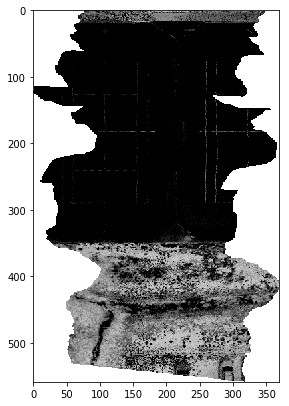

In [13]:
print(rad_map[200,300])
scaled_map = rad_map
scaled_map = bytescale(rad_map)
fig = plt.figure(figsize=(20,8))
gs = gridspec.GridSpec(1, 3, width_ratios=[2, 1, 1])
ax1 = plt.subplot(gs[1])
tmp = ax1.imshow(scaled_map, cmap = "gray_r") #54/34/22<->R/G/B



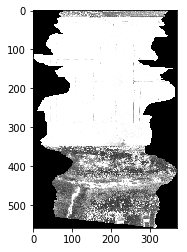

In [12]:
plt.imshow(scaled_map, cmap="gray")
plt.show()

SyntaxError: invalid syntax (<ipython-input-266-20cde670250a>, line 2)

(559, 370, 270)
(559, 1, 270)


D:\Ian\Applications\Anaconda\lib\site-packages\spectral\algorithms\algorithms.py:1478: RuntimeWarning: invalid value encountered in true_divide
  m[i] /= np.sqrt(m[i].dot(m[i]))
D:\Ian\Applications\Anaconda\lib\site-packages\spectral\algorithms\algorithms.py:1486: RuntimeWarning: invalid value encountered in true_divide
  v /= np.sqrt(v.dot(v))


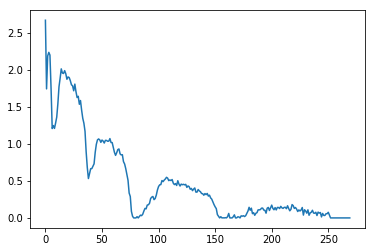

In [10]:
img = open_image('../headwall_data/Radiance/SWIR_CUSouth/headwall_CUS_block0_swir_rad_glt_cor.hdr')
plt.plot(img[50,50])
fake_endmember = (img[:,50])
print(img.shape)
print(fake_endmember.shape)
# a = msam(img, fake_endmember)
ones = np.full((1,img.shape[2]),0.5)
a = msam(img, ones)

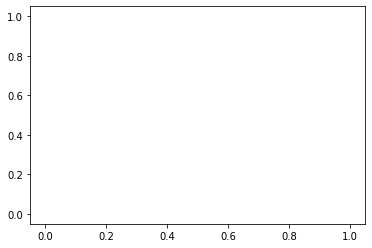

In [6]:
plt.plot(a[50,50])

NameError: name 'box' is not defined

In [ ]:
neon_sub_cube, neon_arrs = extract_from_NEON((xarr_NEON, x_neon, y_neon), chunk1)